In [ ]:
pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error

# Import Data

In [ ]:
from google.colab import drive
df_hourly = pd.read_csv('/content/drive/MyDrive/sampeldata/sampel/AALIh.csv')

In [ ]:
df_minutes = pd.read_csv('/content/drive/MyDrive/sampeldata/sampel/AALIm.csv')

In [ ]:
df_daily = pd.read_csv('/content/drive/MyDrive/sampeldata/sampel/AALId.csv')

In [ ]:
df_hourly['timestamp'] = pd.to_datetime(df_hourly['timestamp'])
df_hourly = df_hourly.set_index('timestamp')
print(f"Jumlah Baris = {df_hourly.shape[0]}")
df_hourly.head()

Jumlah Baris = 5677


,open,low,high,close,volume
timestamp,,,,,
2020-04-16 09:00:00,6700,6425,6700,6500,0
2020-04-16 10:00:00,6525,6450,6550,6450,425300
2020-04-16 11:00:00,6450,6400,6450,6425,303600
2020-04-16 12:00:00,6450,6400,6450,6425,0
2020-04-16 13:00:00,6400,6400,6475,6400,257000


In [ ]:
df_hourly.tail()

,open,low,high,close,volume
timestamp,,,,,
2023-01-06 11:00:00,8050,8025,8050,8050,31900
2023-01-06 12:00:00,0,0,0,0,0
2023-01-06 13:00:00,8050,8025,8050,8050,34900
2023-01-06 14:00:00,8050,8000,8075,8075,92800
2023-01-06 15:00:00,8000,8000,8000,8000,10500


In [ ]:
df_daily['timestamp'] = pd.to_datetime(df_daily['timestamp'])
df_daily = df_daily.set_index('timestamp')
print(f"Jumlah Baris = {df_daily.shape[0]}")
df_daily.head()

Jumlah Baris = 5670


,open,low,high,close,volume
timestamp,,,,,
2001-04-16,524,524,547,547,342131
2001-04-17,547,524,571,524,345804
2001-04-18,547,524,547,524,230361
2001-04-19,524,500,524,500,457574
2001-04-20,476,452,476,452,228262


In [ ]:
df_daily.tail()

,open,low,high,close,volume
timestamp,,,,,
2023-01-02,8025,8000,8050,8050,336800
2023-01-03,8025,8025,8225,8225,1202900
2023-01-04,8200,8125,8375,8125,1040000
2023-01-05,8125,7900,8175,7925,1232100
2023-01-06,7900,7900,8075,8000,298200


In [ ]:
# Menghitung jumlah data
df_daily.describe()

,open,low,high,close,volume
count,5670.000000,5670.000000,5670.000000,5670.000000,5.670000e+03
mean,12844.623986,12659.326455,13037.145326,12839.392416,2.289612e+06
std,7583.048855,7479.553526,7698.951972,7586.886296,4.282093e+06
min,452.000000,452.000000,452.000000,452.000000,0.000000e+00
25%,6527.000000,6407.750000,6654.750000,6550.000000,6.317220e+05
50%,12900.000000,12710.000000,13125.000000,12900.000000,1.301391e+06
75%,19390.000000,19057.000000,19724.000000,19390.000000,2.405018e+06
max,32587.000000,31634.000000,33635.000000,32396.000000,1.333713e+08


In [ ]:
df_daily.count()

open      5670
low       5670
high      5670
close     5670
volume    5670
dtype: int64

In [ ]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5670 entries, 2001-04-16 to 2023-01-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   open    5670 non-null   int64
 1   low     5670 non-null   int64
 2   high    5670 non-null   int64
 3   close   5670 non-null   int64
 4   volume  5670 non-null   int64
dtypes: int64(5)
memory usage: 265.8 KB


In [ ]:
df_daily.isnull()

,open,low,high,close,volume
timestamp,,,,,
2001-04-16,False,False,False,False,False
2001-04-17,False,False,False,False,False
2001-04-18,False,False,False,False,False
2001-04-19,False,False,False,False,False
2001-04-20,False,False,False,False,False
...,...,...,...,...,...
2023-01-02,False,False,False,False,False
2023-01-03,False,False,False,False,False
2023-01-04,False,False,False,False,False


In [ ]:
df_daily.duplicated()

timestamp
2001-04-16    False
2001-04-17    False
2001-04-18    False
2001-04-19    False
2001-04-20    False
              ...  
2023-01-02    False
2023-01-03    False
2023-01-04    False
2023-01-05    False
2023-01-06    False
Length: 5670, dtype: bool

# Visualisasi

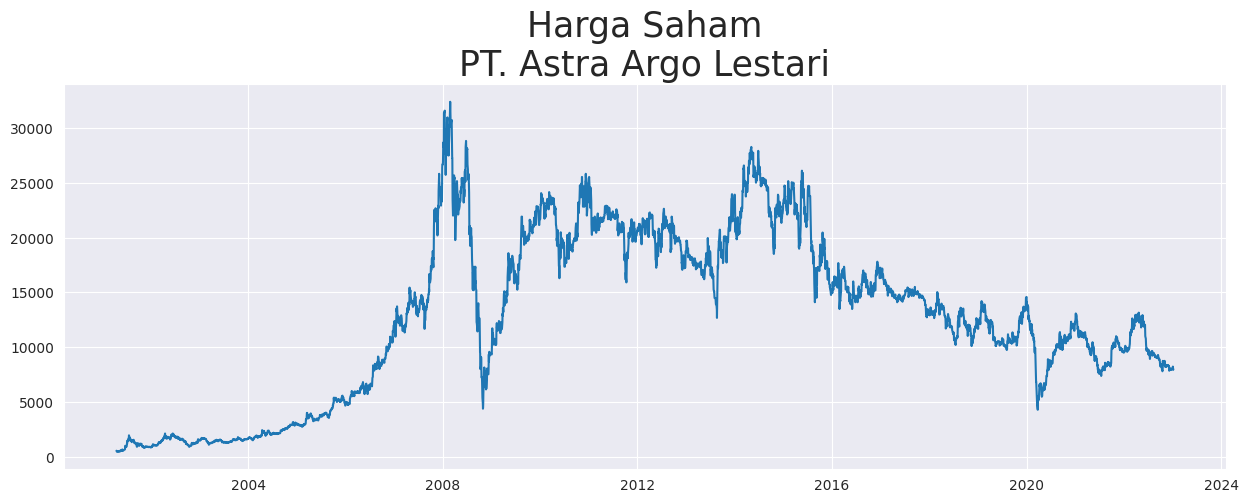

In [ ]:
plt.figure(figsize=(15,5))
sns.set_style('darkgrid')
plt.plot(df_daily.index, df_daily['close'])
plt.title("Harga Saham\nPT. Astra Argo Lestari", fontsize=25)
plt.show()

# Transformasi

In [ ]:
ms = MinMaxScaler()
df_daily['close'] = ms.fit_transform(df_daily[['close']])

# Split Data

In [ ]:
def split_data(df_daily, train_size):
  size = int(len(df_daily) * train_size)
  train, test = df_daily.iloc[0:size], df_daily.iloc[size:len(df_daily)]
  return train, test

In [ ]:
train, test = split_data(df_daily['close'], 0.8) #80% Train

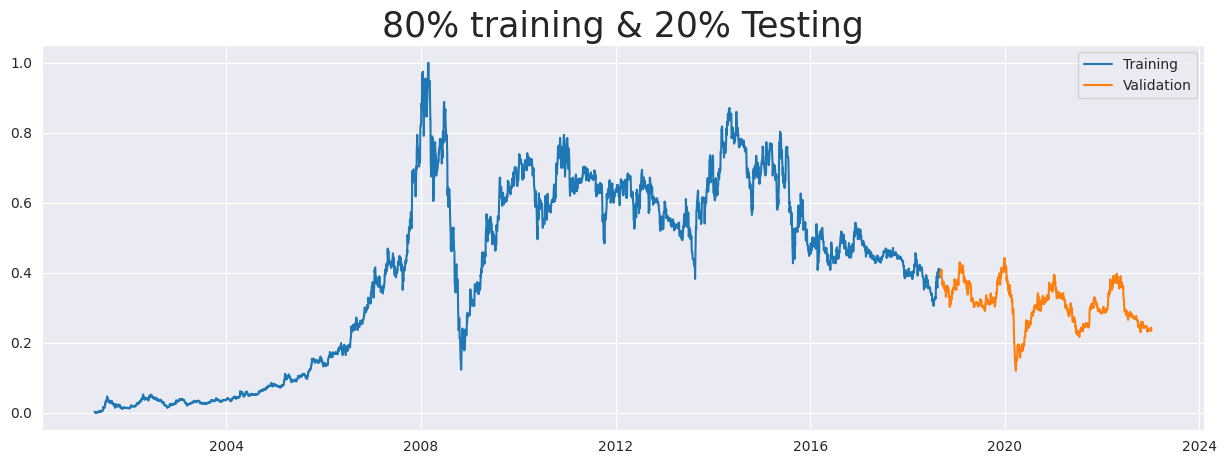

In [ ]:
train, test = split_data(df_daily['close'], 0.8) #80% Train
plt.figure(figsize=(15,5))
plt.plot(train)
plt.plot(test)
plt.legend(labels=['Training', 'Validation'])
plt.title('80% training & 20% Testing', fontsize=25)
plt.show()

In [ ]:
def split_target(df_daily, look_back=1):
    X, y = [], []
    for i in range(len(df_daily) - look_back):
        a = df_daily[i:(i + look_back), 0]
        X.append(a)
        y.append(df_daily[i + look_back, 0])
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = split_target(train.values.reshape(len(train), 1))
X_test, y_test = split_target(test.values.reshape(len(test), 1))

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build Model


In [ ]:
model = Sequential([LSTM(100, input_shape=(1, 1), return_sequences=True),
                    LSTM(50),
                    Dense(25, activation='relu'),
                    Dense(1)])

In [ ]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.015:
      self.model.stop_training = True

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              metrics=["mae"],
              loss=tf.keras.losses.Huber())

# Training Model

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=2000,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks=[Callback()])

Epoch 1/2000
36/36 [==============================] - 6s 37ms/step - loss: 0.1115 - mae: 0.3972 - val_loss: 0.0432 - val_mae: 0.2885
Epoch 2/2000
36/36 [==============================] - 0s 11ms/step - loss: 0.1025 - mae: 0.3760 - val_loss: 0.0372 - val_mae: 0.2667
Epoch 3/2000
36/36 [==============================] - 0s 10ms/step - loss: 0.0933 - mae: 0.3556 - val_loss: 0.0311 - val_mae: 0.2433
Epoch 4/2000
36/36 [==============================] - 0s 10ms/step - loss: 0.0835 - mae: 0.3367 - val_loss: 0.0250 - val_mae: 0.2169
Epoch 5/2000
36/36 [==============================] - 0s 11ms/step - loss: 0.0732 - mae: 0.3165 - val_loss: 0.0189 - val_mae: 0.1867
Epoch 6/2000
36/36 [==============================] - 0s 11ms/step - loss: 0.0623 - mae: 0.2946 - val_loss: 0.0130 - val_mae: 0.1526
Epoch 7/2000
36/36 [==============================] - 0s 10ms/step - loss: 0.0512 - mae: 0.2707 - val_loss: 0.0078 - val_mae: 0.1153
Epoch 8/2000
36/36 [==============================] - 1s 25ms/step - 

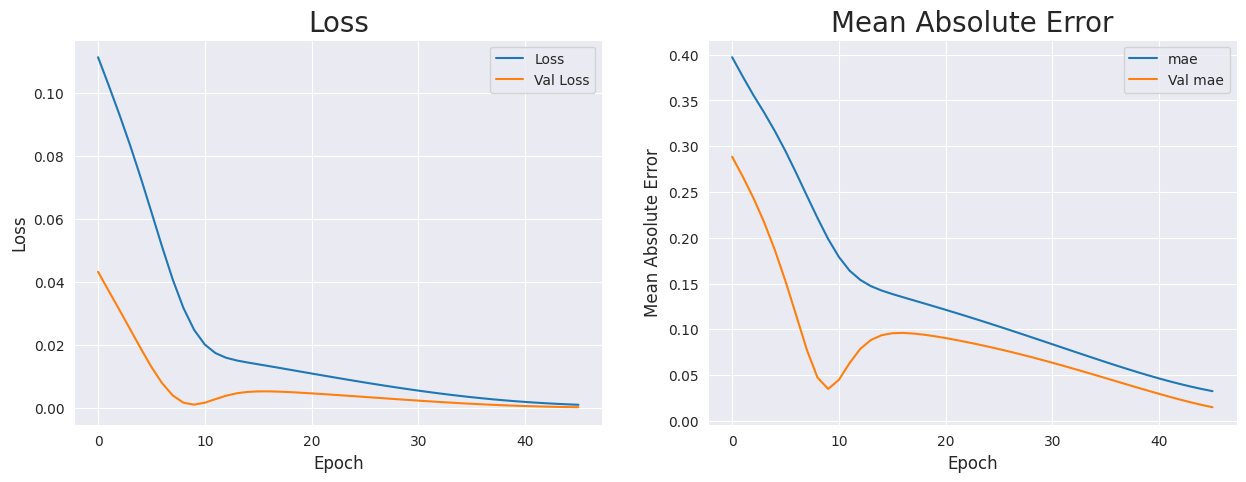

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

# Predict

36/36 [==============================] - 1s 3ms/step


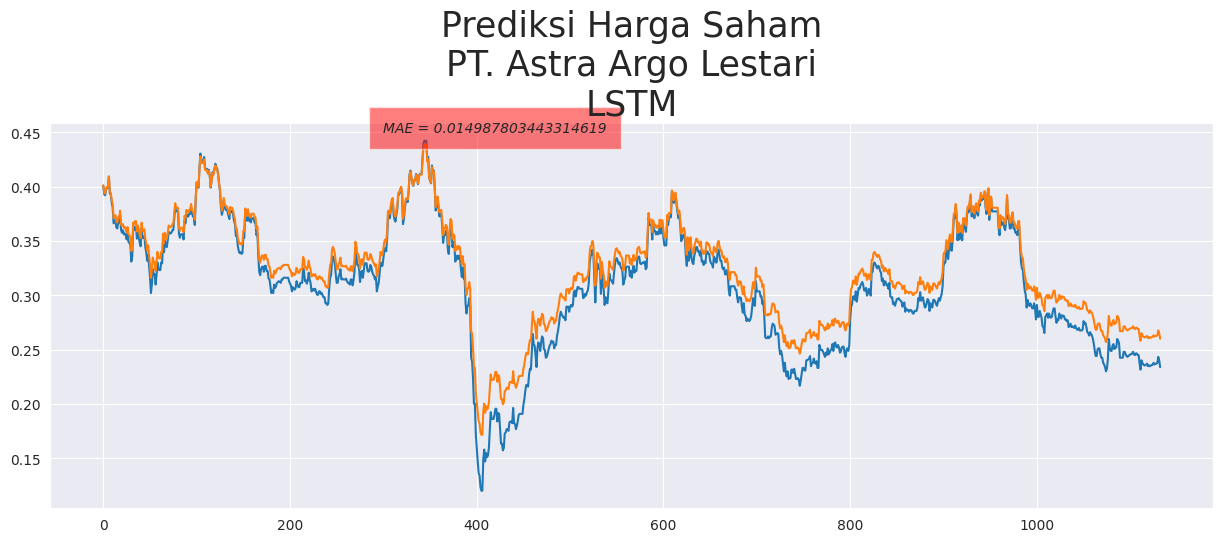

In [ ]:
plt.figure(figsize=(15,5))
y_pred = model.predict(X_test)
y_pred = list(np.reshape(y_pred, (1,len(y_pred)))[0])

X_test = np.reshape(X_test, (len(X_test),1))
X_test = list(np.reshape(X_test, (1,len(X_test)))[0])

plt.plot(X_test)
plt.plot(y_pred)
plt.text(300, 0.45, f"MAE = {mean_absolute_error(y_test, y_pred)}", style='italic', bbox={
        'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.title('Prediksi Harga Saham\nPT. Astra Argo Lestari\nLSTM', fontsize=25)
plt.show()